<a href="https://colab.research.google.com/github/sanjabh11/Projects/blob/master/Loan_default68_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular models

In [0]:
import fastai
fastai.__version__

'1.0.55'

In [0]:
from fastai.tabular import *
from fastai.callbacks import *

In [0]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
!cp '/drive/My Drive/loan/stage-1.pth' /content/loan/models

In [0]:
!cp /content/loan/models/stage-1.pth '/drive/My Drive/loan'

In [0]:
!cp /content/loan/models/stage-1.pth '/drive/My Drive/loan'

In [0]:
!mv /content/loan/stage-1.pth models

Tabular data should be in a Pandas `DataFrame`.

In [0]:
path = '/content/loan'
df = pd.read_csv('/content/loan/train_loan1.csv')

In [0]:
df_test= pd.read_csv('/content/loan/test_loan1.csv')

In [0]:
sorted(df['PERFORM_CNS.SCORE.DESCRIPTION'].unique())

In [0]:
#Extracting yyyy
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'])
df['Date.of.Birth'] = df['Date.of.Birth'].dt.year
df['Date.of.Birth'].head()

0    1984
1    1985
2    1985
3    1993
4    1977
Name: Date.of.Birth, dtype: int64

In [0]:
df_test['Date.of.Birth'] = pd.to_datetime(df_test['Date.of.Birth'])
df_test['Date.of.Birth'] = df_test['Date.of.Birth'].dt.year
df_test['Date.of.Birth'].head()

0    1974
1    1985
2    1995
3    1973
4    1972
Name: Date.of.Birth, dtype: int64

In [0]:
df_test['Date.of.Birth'].head()

0    1974
1    1985
2    1995
3    1973
4    1972
Name: Date.of.Birth, dtype: int64

In [0]:
dep_var = 'loan_default'
cat_names = ['Employment.Type', 'PERFORM_CNS.SCORE','Aadhar_flag','PAN_flag','Passport_flag','Current_pincode_ID',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NEW.ACCTS.IN.LAST.SIX.MONTHS']
cont_names = ['asset_cost','ltv', 'CREDIT.HISTORY.LENGTH','PRI.CURRENT.BALANCE',  'Date.of.Birth',
              'AVERAGE.ACCT.AGE', 'PRI.OVERDUE.ACCTS','PRI.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT', 'PRI.ACTIVE.ACCTS',
             'NO.OF_INQUIRIES','PRI.SANCTIONED.AMOUNT','disbursed_amount', 'SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT', 'State_ID']
procs = [FillMissing, Categorify, Normalize]
#, 'disbur date', ', 'SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT', 'State_ID',
#'UniqueID',,'VoterID_flag','PRI.NO.OF.ACCTS', 'Driving_flag','SEC.ACTIVE.ACCTS',, 'PERFORM_CNS.SCORE.DESCRIPTION'
#'SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
             

In [0]:
#valid_idx=np.random.randint(len(df), size=1200)
#test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)
test = TabularList.from_df(df_test, path=path, cat_names=cat_names, cont_names=cont_names)
#valid_idx = range(len(df)-200, len(df))
#test = TabularList.from_df(df.iloc[800:2000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(len(df)-500,len(df)))
                         #  .split_by_rand_pct(0.1)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
data.show_batch(rows=10)

In [0]:
#Define function for AUC..https://forums.fast.ai/t/using-auc-as-metric-in-fastai/38917/7
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [0]:
#learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
#learn = tabular_learner(data,layers=[100,200,300],emb_drop=0.,metrics=accuracy), ps=[0.3, 0.3, 0.3], 
#learn = tabular_learner(data, layers=[100,300,600], metrics=accuracy, callback_fns=AUROC)
learn = tabular_learner(data, layers=[1000,500,300], emb_drop=0.04, metrics=accuracy, callback_fns=AUROC)

#rossmann layers=[1000,500,300], ps=[0.1,0.1], emb_drop=0.04

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


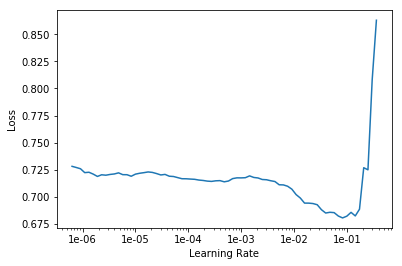

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 5e-3)
                    #,callbacks=[SaveModelCallback(learn,monitor='accuracy',mode='max'),CSVLogger(learn,filename='ensemble')])


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.516493,0.568068,0.726000,0.631759,00:31
1,0.502349,0.551159,0.728000,0.675172,00:33
2,0.482323,0.555085,0.736000,0.668195,00:31


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1-17')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


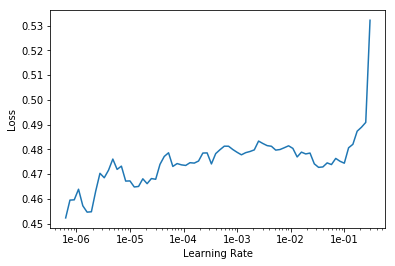

In [0]:
learn.unfreeze
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.481682,0.546984,0.728000,0.689148,00:33
1,0.484115,0.548560,0.728000,0.686433,00:32
2,0.476258,0.548709,0.726000,0.687881,00:33


In [0]:
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


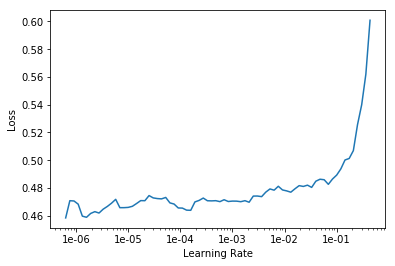

In [0]:
learn.unfreeze
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 8e-7)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.477350,0.547010,0.732000,0.686332,00:32
1,0.480294,0.547913,0.732000,0.686172,00:33
2,0.478316,0.548020,0.724000,0.688223,00:32


In [0]:
learn.save('stage-3-17')

In [0]:
learn.load('stage-3-17')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


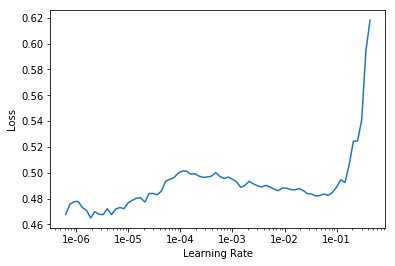

In [0]:
learn.unfreeze
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.464327,0.548457,0.728000,0.684885,00:31
1,0.477704,0.548341,0.726000,0.688142,00:33
2,0.476409,0.546791,0.732000,0.687418,00:32


In [0]:
#https://www.kaggle.com/davidsalazarv95/fast-ai-pytorch-starter-version-two
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, preds_binary)
plot_confusion_matrix(cm, [0, 1])

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_valid,
                            preds_binary,
                            target_names= ['0', '1']))

from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_valid,
                                                               preds_valid)

## Inference

In [0]:
row = df.iloc[200]

In [0]:
learn.predict(row)

(Category 0, tensor(0), tensor([0.7716, 0.2284]))

In [0]:
#How t odraw ROC curve AUC-->https://forums.fast.ai/t/roc-curve-how-to-graph/13940/3
valid_idx = range(len(df)-1500,len(df)
valid_set = df.iloc[valid_idx, :]
preds = learn.get_preds()
y_score = preds[0][:,1].numpy()
y_test = valid_set.label.values

In [0]:
preds = learn.get_preds()
y_score = preds[0][:,1].numpy()


In [0]:
y_test = test.labels.values

In [0]:
def roc_auc(preds, y):                                                                                                                                                                                         
      return metrics.roc_auc_score(y.data.cpu().numpy(), np.exp(preds.cpu().numpy())) 

In [0]:
def roc_auc(preds, y):
  preds = np.exp(preds) #conv from logs
  exp = V(y).data.cpu().numpy() #predicted category ID
  #batch X num_classes
  bs = preds.shape[0] #batch size
  nclass = preds.shape[1] #size to determine length of Y one hot encoding
  y = np.zeros((bs, nclass))
  y[np.arange(bs), exp] = 1 #one hot encode Ys
  return metrics.roc_auc_score(y, preds, average="micro")

In [0]:
preds_test = learn.get_preds (DatasetType.Test)


In [0]:
type(preds_test), len(preds_test)

(list, 2)

In [0]:
test_preds, test_ys = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
type(test_preds), test_preds.shape,  test_ys.shape

(torch.Tensor, torch.Size([112392, 2]), torch.Size([112392]))

In [0]:
test_preds, test_ys

(tensor([[0.7076, 0.2924],
         [0.5826, 0.4174],
         [0.8012, 0.1988],
         ...,
         [0.6484, 0.3516],
         [0.0722, 0.9278],
         [0.7896, 0.2104]]), tensor([0, 0, 0,  ..., 0, 0, 0]))

In [0]:
testprobs = np.exp(test_preds) / np.exp(test_preds).sum(1)[:,None]

In [0]:
test_probs = testprobs.tolist()

In [0]:
my_df = pd.DataFrame(test_probs)
my_df.to_csv('submission.csv')

In [0]:
test_probs.

In [0]:
#https://github.com/berndheidemann/notebooks_fastai/blob/master/titanic.ipynb
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
labels

In [0]:

res_df = pd.DataFrame({'UniqueID': df_test['UniqueID'], 'loan_default': labels})
res_df.to_csv('loan_submission.csv', index=False)


tensor([0, 0, 0,  ..., 0, 1, 0])